### D214 - Data Analytics Graduate Capstone
### Correlation Between the Estimated Sentiments of Tweets and the Change in Bitcoin Prices

-------------------------------------------------------------------------------------------------------------

In [1]:
#importing the needed libraries
import pandas as pd
#modified Pandas options to fully display the large dataset when needed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from textblob import TextBlob

import scipy.stats as stats
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore') # Ignore warning messages for readability

In [2]:
# Bitcoin twitter Data
#https://www.kaggle.com/kaushiksuresh147/bitcoin-tweets
#Bitcoin Tweets
df_Bitcoin_tweets = pd.read_csv('Bitcoin_tweets.csv')
df_Bitcoin_tweets.drop_duplicates(subset=['user_followers','date','text'],inplace=True)
df_Bitcoin_tweets.sort_values(by='date',inplace=True)
print('df_Bitcoin_tweets dimensions= ',df_Bitcoin_tweets.shape)
df_Bitcoin_tweets=df_Bitcoin_tweets[['user_followers','date','text']]
df_Bitcoin_tweets.head()

df_Bitcoin_tweets dimensions=  (346512, 13)


user_followers                 date  \
21523           301.0  2021-02-05 10:52:04   
21524           301.0  2021-02-05 10:52:04   
21522           301.0  2021-02-05 10:52:06   
21521           301.0  2021-02-05 10:52:07   
21520            37.0  2021-02-05 10:52:26   

                                                                                                                                                 text  
21523          2⃣   Debunking 9 #Bitcoin Myths by @Patrick_Lowry_  ⬇️  \n\n#cryptocurrency #bitcoin #crypto #blockchain #btc… https://t.co/2CM83fuB2n  
21524  📖  Weekend Read 📖\n\nKeen to learn about #crypto assets? Check out our reading list! \n1⃣   2021 CryptoMarket Outlook… https://t.co/opiev94qzl  
21522    4⃣  🎙️ Bloomberg LP #CryptoOutlook 2021 with @mikemcglone11 ⬇️\n\n#cryptocurrency #bitcoin #crypto #blockchain #btc… https://t.co/gC3VNGAP6v  
21521    5⃣   #Blockchain 50 2021 by @DelRayMan, @Forbes , @ForbesCrypto  ⬇️\n\n#cryptocurrency #bitcoin #crypto #blockchain… https://t.co/L3Xj7j49Fx  
21520                                #reddcoin #rdd @reddcoin to the moon #altcoin #turnreddcoinin1dollar #eth #btc #bitcoin  https://t.co/ycm15VolsW

In [3]:
# Bitcoin Price Data
#BTCUSD
#https://www.kaggle.com/maxwells/btcusd
df_Bitcoin_Price= pd.read_csv('BTCUSD_1.csv')
df_Bitcoin_Price['time'] = pd.to_datetime(df_Bitcoin_Price['time'])
# Set time column as index
df_Bitcoin_Price.set_index('time',drop=True,inplace=True)
print('df_Bitcoin_Price dimensions= ',df_Bitcoin_Price.shape)
df_Bitcoin_Price=df_Bitcoin_Price[['close']]
df_Bitcoin_Price.tail()

df_Bitcoin_Price dimensions=  (1629299, 5)


close
time                         
2021-06-15 15:56:00  40251.14
2021-06-15 15:57:00  40308.39
2021-06-15 15:58:00  40345.39
2021-06-15 15:59:00  40406.24
2021-06-15 16:00:00  40378.25

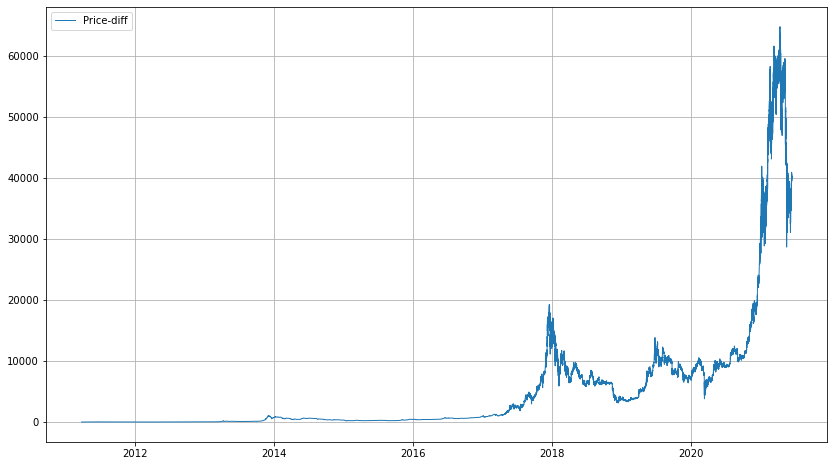

In [4]:
# Plot and show the time series on axis ax
fig, ax = plt.subplots(figsize = (14,8))
plt.plot(df_Bitcoin_Price.index, 
         (df_Bitcoin_Price[['close']]), 
         linewidth=1,)
#plt.ylim([0,3500])
plt.legend(['Price-diff'],loc='upper left')

plt.grid()
plt.show()

In [5]:
### Dataset Cleaning - tweets cleaning
# Edited after (Naik,2020)

def cleantxt(text):
    text=str(text)
    text = text.lower() #Converting Capital chars into small
    text = re.sub(r'@[a-zA-Z0-9]+', ' ', text) #Removing @ mentions
    text = re.sub("#bitcoin", 'bitcoin', text) # removeing the '#' from bitcoin
    text = re.sub("#btc", 'btc', text) # removeing the '#' from btc
    #text = re.sub('#[A-Za-z0-9]+', '', text) # removing any hastag or string starting with a '#'
    text = re.sub('\\n', '', text) # removing the '\n' string
    text = re.sub(r'https?:\/\/\S+', ' ', text) #Removing hyper links
    #text = re.sub(r'[^a-zA-Z]+', ' ', text) #Removing non ASCII chars
    text = text.split() #Removing extra spaces
    text = ' '.join(text)
    return text

In [6]:
### Dataset Cleaning - date cleaning

def cleandate(date):
    date=str(date)
    date = re.sub(r'[^0-9\-\:]', ' ', date) #Removing non ASCII chars
    date = date.split() #Removing extra spaces
    date = ' '.join(date)
    return date

In [7]:
df_Bitcoin_tweets['text']=df_Bitcoin_tweets['text'].apply(cleantxt)
df_Bitcoin_tweets['date']=df_Bitcoin_tweets['date'].apply(cleandate)
df_Bitcoin_tweets.dropna(inplace=True)
df_Bitcoin_tweets.drop(df_Bitcoin_tweets[df_Bitcoin_tweets['text'].str.len()==0].index,inplace=True)

df_Bitcoin_tweets['date'] = pd.to_datetime(df_Bitcoin_tweets['date'])

# Set date column as index
df_Bitcoin_tweets.set_index('date',drop=False, inplace=True)

In [8]:
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [9]:
df_Bitcoin_tweets['subj']=df_Bitcoin_tweets['text'].apply(getsubjectivity)
df_Bitcoin_tweets['polarity']=df_Bitcoin_tweets['text'].apply(getpolarity)
df_Bitcoin_tweets['count']=1

In [10]:
df_Bitcoin_tweets['polarity'] = df_Bitcoin_tweets['polarity'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else x))
df_Bitcoin_tweets.head(10)

user_followers                date  \
date                                                      
2021-02-05 10:52:04           301.0 2021-02-05 10:52:04   
2021-02-05 10:52:04           301.0 2021-02-05 10:52:04   
2021-02-05 10:52:06           301.0 2021-02-05 10:52:06   
2021-02-05 10:52:07           301.0 2021-02-05 10:52:07   
2021-02-05 10:52:26            37.0 2021-02-05 10:52:26   
2021-02-05 10:53:49           100.0 2021-02-05 10:53:49   
2021-02-05 10:54:52            69.0 2021-02-05 10:54:52   
2021-02-05 10:57:05           163.0 2021-02-05 10:57:05   
2021-02-05 10:58:03          2520.0 2021-02-05 10:58:03   
2021-02-05 10:58:36          1036.0 2021-02-05 10:58:36   

                                                                                                                                   text  \
date                                                                                                                                      
2021-02-05 10:52:04                         2⃣ debunking 9 bitcoin myths by _lowry_ ⬇️ #cryptocurrency bitcoin #crypto #blockchain btc…   
2021-02-05 10:52:04       📖 weekend read 📖keen to learn about #crypto assets? check out our reading list! 1⃣ 2021 cryptomarket outlook…   
2021-02-05 10:52:06                      4⃣ 🎙️ bloomberg lp #cryptooutlook 2021 with ⬇️#cryptocurrency bitcoin #crypto #blockchain btc…   
2021-02-05 10:52:07                                        5⃣ #blockchain 50 2021 by , , ⬇️#cryptocurrency bitcoin #crypto #blockchain…   
2021-02-05 10:52:26                                         #reddcoin #rdd to the moon #altcoin #turnreddcoinin1dollar #eth btc bitcoin   
2021-02-05 10:53:49  bitcoin and #eth both have bullish setups for a move higher ... btc it would just be great if daily close (in abo…   
2021-02-05 10:54:52      $perl 0.06.i have insisted that since 0.02 it will be 0.071. it increased 300% in about 2 months. bitcoin btc…   
2021-02-05 10:57:05              #amazing 😍#monopoly #crypto #cryptocurrency #cryptocurrencies #cryptonews #cryptotrading #ripple #xrp…   
2021-02-05 10:58:03              $juld $bnb #binance #bsc #binancesmartchain btc bitcoin $btc $eth $uni $sushi $cake #1inch $link $xrp…   
2021-02-05 10:58:36                                               amazoncoin = 100% love💚 👉👉 #amazoncoin #crypto #defi #cryptocurrency…   

                         subj  polarity  count  
date                                            
2021-02-05 10:52:04  0.000000       0.0      1  
2021-02-05 10:52:04  0.000000       0.0      1  
2021-02-05 10:52:06  0.000000       0.0      1  
2021-02-05 10:52:07  0.000000       0.0      1  
2021-02-05 10:52:26  0.000000       0.0      1  
2021-02-05 10:53:49  0.416667       1.0      1  
2021-02-05 10:54:52  0.000000       0.0      1  
2021-02-05 10:57:05  0.900000       1.0      1  
2021-02-05 10:58:03  0.000000       0.0      1  
2021-02-05 10:58:36  0.000000       0.0      1

<AxesSubplot:>

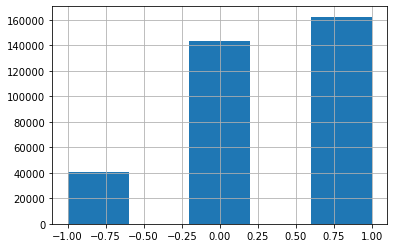

In [11]:
df_Bitcoin_tweets['polarity'].hist(bins=5)

In [12]:
df_Bitcoin_tweets=df_Bitcoin_tweets.resample('Min').sum()

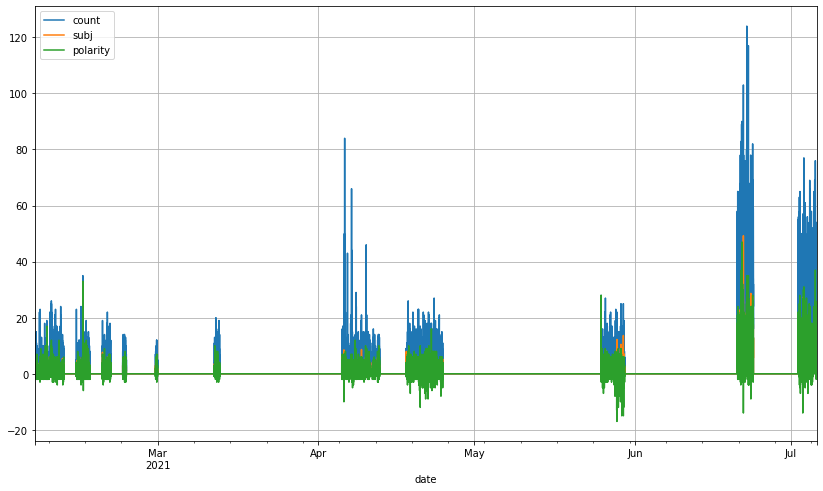

In [13]:
# Plot and show the time series on axis ax
fig, ax = plt.subplots(figsize = (14,8))
df_Bitcoin_tweets[['count','subj','polarity']].plot(ax=ax)
plt.grid()
plt.show()

In [14]:
df_Bitcoin_Price['diff']=df_Bitcoin_Price['close'].diff()
df_Bitcoin_Price=df_Bitcoin_Price[['diff']]

In [15]:
start_time=max(df_Bitcoin_tweets.index.min(),df_Bitcoin_Price.index.min())
end_time=min(df_Bitcoin_tweets.index.max(),df_Bitcoin_Price.index.max())
df_Bitcoin_Price=df_Bitcoin_Price.loc[(df_Bitcoin_Price.index >= start_time) & (df_Bitcoin_Price.index  <= end_time)]
df_Bitcoin_tweets=df_Bitcoin_tweets.loc[(df_Bitcoin_tweets.index >= start_time) & (df_Bitcoin_tweets.index  <= end_time)]

df_Bitcoin_price_tweets = pd.concat([df_Bitcoin_Price, df_Bitcoin_tweets], axis=1)

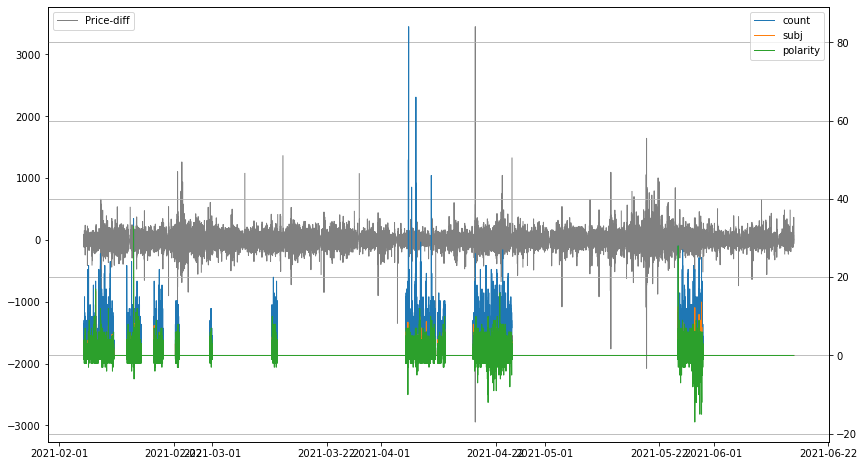

In [16]:
# Plot and show the time series on axis ax
fig, ax = plt.subplots(figsize = (14,8))
plt.plot(df_Bitcoin_price_tweets.index, 
         (df_Bitcoin_price_tweets[['diff']]),
         color='gray', 
         linewidth=1,)
#plt.ylim([0,3500])
plt.legend(['Price-diff'],loc='upper left')

ax.twinx()

plt.plot(df_Bitcoin_price_tweets.index, 
         df_Bitcoin_price_tweets[['count','subj','polarity']],
         linewidth=1,)
#plt.ylim([0,100])
plt.legend(['count','subj','polarity'],loc='upper right')

plt.grid()
plt.show()

In [17]:
df_Bitcoin_price_tweets['count'].replace(0.0, np.NaN,inplace=True) #
df_Bitcoin_price_tweets=df_Bitcoin_price_tweets[(~df_Bitcoin_price_tweets['count'].isnull() & ~df_Bitcoin_price_tweets['diff'].isnull())]

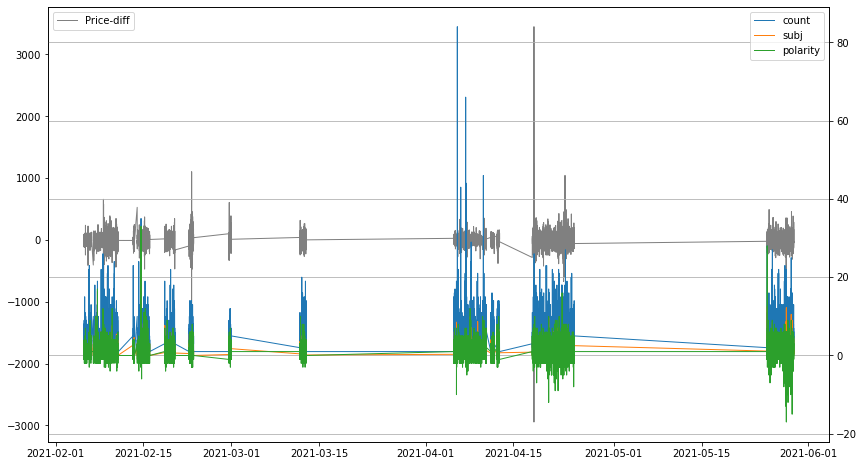

In [18]:
# Plot and show the time series on axis ax
fig, ax = plt.subplots(figsize = (14,8))
plt.plot(df_Bitcoin_price_tweets.index, 
         (df_Bitcoin_price_tweets[['diff']]),
         color='gray', 
         linewidth=1,)
#plt.ylim([0,3500])
plt.legend(['Price-diff'],loc='upper left')

ax.twinx()

plt.plot(df_Bitcoin_price_tweets.index, 
         df_Bitcoin_price_tweets[['count','subj','polarity']],
         linewidth=1,)
#plt.ylim([0,100])
plt.legend(['count','subj','polarity'],loc='upper right')

plt.grid()
plt.show()

In [19]:
df_Bitcoin_price_tweets_1min=df_Bitcoin_price_tweets.copy()
#df_Bitcoin_price_tweets.index=df_Bitcoin_price_tweets.index.astype(str)
df_Bitcoin_price_tweets.reset_index(drop=True,inplace= True)

df_Bitcoin_price_tweets dimensions=  (36771, 5)


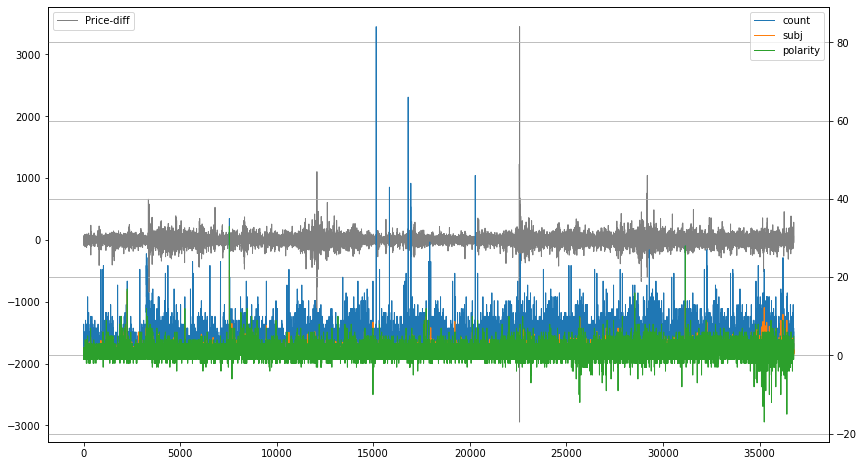

In [20]:
print('df_Bitcoin_price_tweets dimensions= ',df_Bitcoin_price_tweets.shape) 

# Plot and show the time series on axis ax
fig, ax = plt.subplots(figsize = (14,8))
plt.plot(df_Bitcoin_price_tweets.index, 
         (df_Bitcoin_price_tweets[['diff']]),
         color='gray', 
         linewidth=1,)
#plt.ylim([0,3500])
plt.legend(['Price-diff'],loc='upper left')

ax.twinx()

plt.plot(df_Bitcoin_price_tweets.index, 
         df_Bitcoin_price_tweets[['count','subj','polarity']],
         linewidth=1,)
#plt.ylim([0,100])
plt.legend(['count','subj','polarity'],loc='upper right')

plt.grid()
plt.show()

In [21]:
'''Custom function to inspect the data visually using Histogram/Bar, Boxplot and scattered plots
this function takes 3 parameters, 1st is DataFrame , 2nd is the preferable plot ("hist" , "box" , " scat" , "target_scat" or "target_histplot" )
The target argument will be used only in the case of target vs variables scat plots, and will not be used for other options
For Histograms with non-numeric columns , the function will use Bar charts (in Green color) instead of Histogram
"scat": plotting scatterd plot against the 1st column of the D.F.
"target_scat": plotting scatterd plot of num. variables against a 'target' column of the D.F.
"target_histplot":plotting histplot of numeric or countplot of cat. variables against the target' column 
'''

def plt_summary(df_1,plt_type,target):
    numerics = ['uint8','uint16','uint32','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    if plt_type =='target_histplot':
        pltlist=df_1.columns
#         for number,cols in enumerate(df_1.columns):
#             if (len(df_1[cols].value_counts())>=20):
#                 pltlist.remove(cols)
        print("Plot Type:  "+plt_type) #Printing plot type.
        print("Number of columns:  "+str(len(pltlist))) #Printing the number of columns.
        
        
    elif plt_type =='hist':
        pltlist=df_1.columns
        print("Plot Type:  "+plt_type) #Printing plot type.
        print("Number of columns:  "+str(df_1.shape[1])) #Printing the number of columns.
        
    else :
        df_n = df_1.select_dtypes(include=numerics).copy()   # selecting only the numeric columns as it's suitable for mentioned plots
        pltlist=df_n.columns
        print("Plot Type:  "+plt_type) #Printing plot type.
        print("Number of Numeric columns:  "+str(df_n.shape[1])) #Printing the number of numeric columns.

    
    plt.style.use('default')
    plt.figure(figsize=(15,30))
    plt_rows = 11
    plt_cols = 5
    
    for n, col in enumerate(pltlist):   #enumerating each column of the data, starting from index
        b=n+1
        ax=plt.subplot2grid(shape=(plt_rows,plt_cols),loc=((int(np.ceil(b/plt_cols)-1)),((b-1)%plt_cols)))
        if plt_type == 'hist':
            if df_1[col].dtype in numerics:
                ax.hist(df_1.loc[:,col],bins = 50)  #plotting Histogram
                ax.set_title(str(col)+' (*num)')
            else:
                if len(df_1[col].value_counts())>2000:
                    ax.set_title(str(col)+' ('+str(len(df_1[col].value_counts()))+' unq val.)')
                    continue
                df_1.groupby(col).size().plot.bar(rot=0,color='g') #plotting Bar chart
                ax.set_title(str(col)+' (*categ. '+str(len(df_1[col].value_counts()))+' cat.)')
                if len(df_1[col].value_counts())>20:
                    ax.tick_params(bottom=False,labelbottom=False)
                    
        elif plt_type == 'box':
            msk = ~np.isnan(df_n.loc[:,col])
            ax.boxplot(df_n.loc[msk,col])  #plotting Box plot (used a mask to filter the null values)
            #ax.boxplot(df.loc[:,col])
            ax.set_title(col)
        elif plt_type == 'scat':
            ax.scatter(df_n.iloc[:,0],df_n.loc[:,col],s=0.1,alpha=0.1) #plotting scatterd plot against the index of the D.F.
            ax.set_title(col)
            
        elif plt_type == 'target_scat':
            ax.scatter(df_n.loc[:,col],df_n.loc[:,target],s=1,alpha=0.1,color='b') #plotting scatterd plot of num. variables against the 'target' column of the D.F.
            #ax.set_title(col)
            ax.set_xlabel(col)
            
        elif plt_type == 'target_hexbin':
            ax = df_n.plot.hexbin(ax=ax,x=col, y=target,gridsize=50, sharex=False) #plotting hexbin plot
            ax.set_title(col)
            
        elif (plt_type == 'target_histplot'):
            if (df_1[target].dtype not in numerics):
                ax.set_title(str(col)+' (*categ. '+str(len(df_1[col].value_counts()))+' cat.)')
                if (len(df_1[col].value_counts())<=700):
                    sns.countplot(ax=ax, data = df_1,x = col,hue = target,alpha=0.7) #plotting countplot of cat. variables against the 'target' column
                    if len(df_1[col].value_counts())>20:
                        ax.tick_params(bottom=False,labelbottom=False)
                elif (df_1[col].dtype in numerics):
                        sns.histplot(df_1, x=col, hue=target, element="poly",ax=ax) #plotting histplot of num. variables against the 'target' column
                        ax.set_title(str(col)+' (*num)')
#                         ax.plt.legend(fontsize='xx-small', title_fontsize='xx-small')
#                         plt.setp(ax.get_legend().get_texts(), fontsize='5') # for legend text
#                         plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title                        
            elif df_1[target].dtype in numerics:
                if (df_1[col].dtype not in numerics):
                    ax.set_title(str(col)+' (*categ. '+str(len(df_1[col].value_counts()))+' cat.)')
                    if (len(df_1[col].value_counts())<=5):
                        sns.histplot(df_1, x=target, hue=col, element="poly",ax=ax) #plotting histplot of num. variables against the 'target' column
                elif (df_1[col].dtype in numerics):
                    ax = df_1.plot.hexbin(ax=ax,x=target, y=col,gridsize=30, sharex=False, cmap="cubehelix_r") #plotting hexbin plot
#                     continue
                           
            
                
    plt.tight_layout()
    plt.show() 
   
    return 

Plot Type:  hist
Number of columns:  5


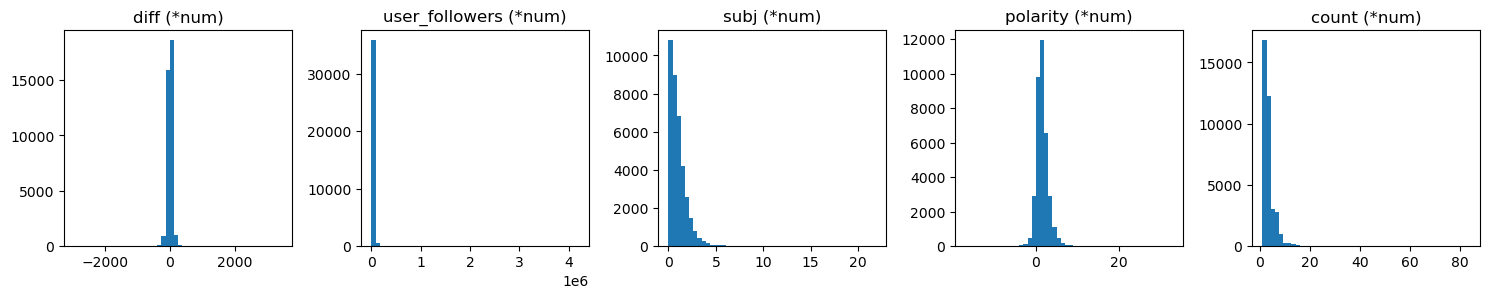

Plot Type:  box
Number of Numeric columns:  5


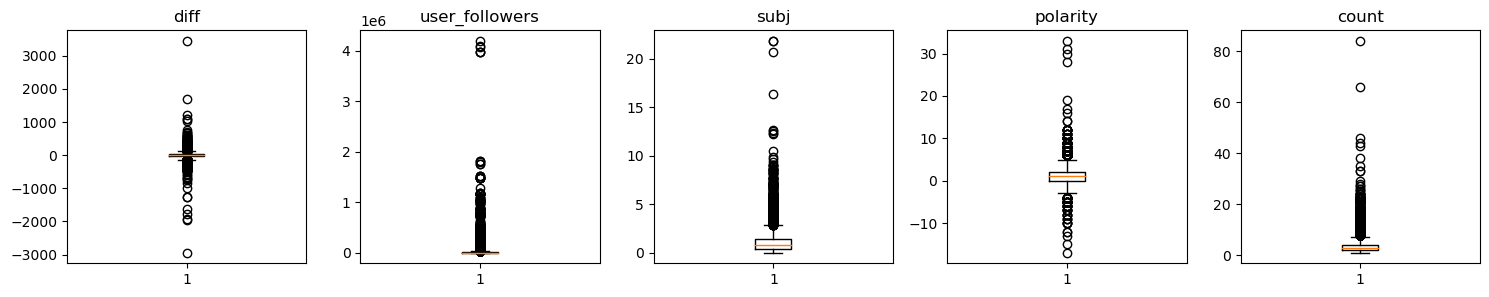

Plot Type:  target_scat
Number of Numeric columns:  5


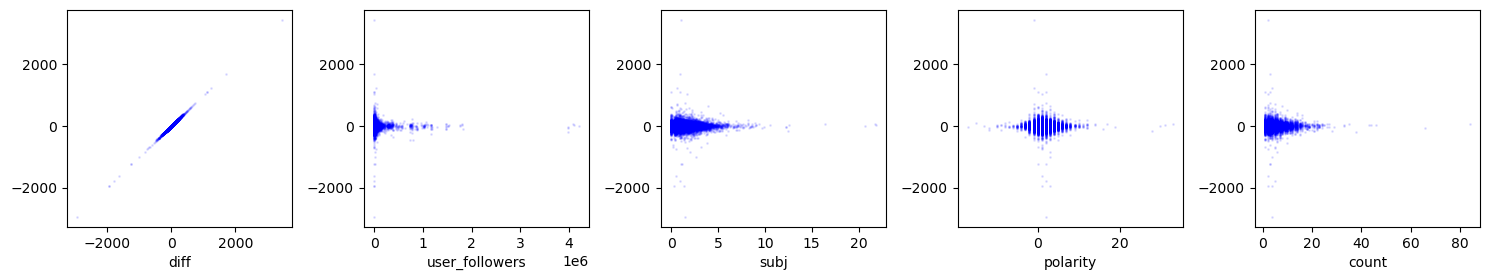

In [22]:
plt_summary(df_Bitcoin_price_tweets,'hist','diff')
plt_summary(df_Bitcoin_price_tweets,'box','diff')
plt_summary(df_Bitcoin_price_tweets,"target_scat",'diff')

In [23]:
df_otl = df_Bitcoin_price_tweets.copy()

q1=df_otl.quantile(0.25)
q3=df_otl.quantile(0.75)
iqr=q3-q1
pmin=q1-iqr*1.5
pmax=q3+iqr*1.5
otl_cols = ['diff','count','polarity','subj','user_followers']
for n,col in enumerate(otl_cols):  
    df_otl.loc[:,col]=df_otl.loc[:,col].where(df_otl.loc[:,col].between(pmin[col],pmax[col]))
        
df_Bitcoin_price_tweets = df_otl.copy()

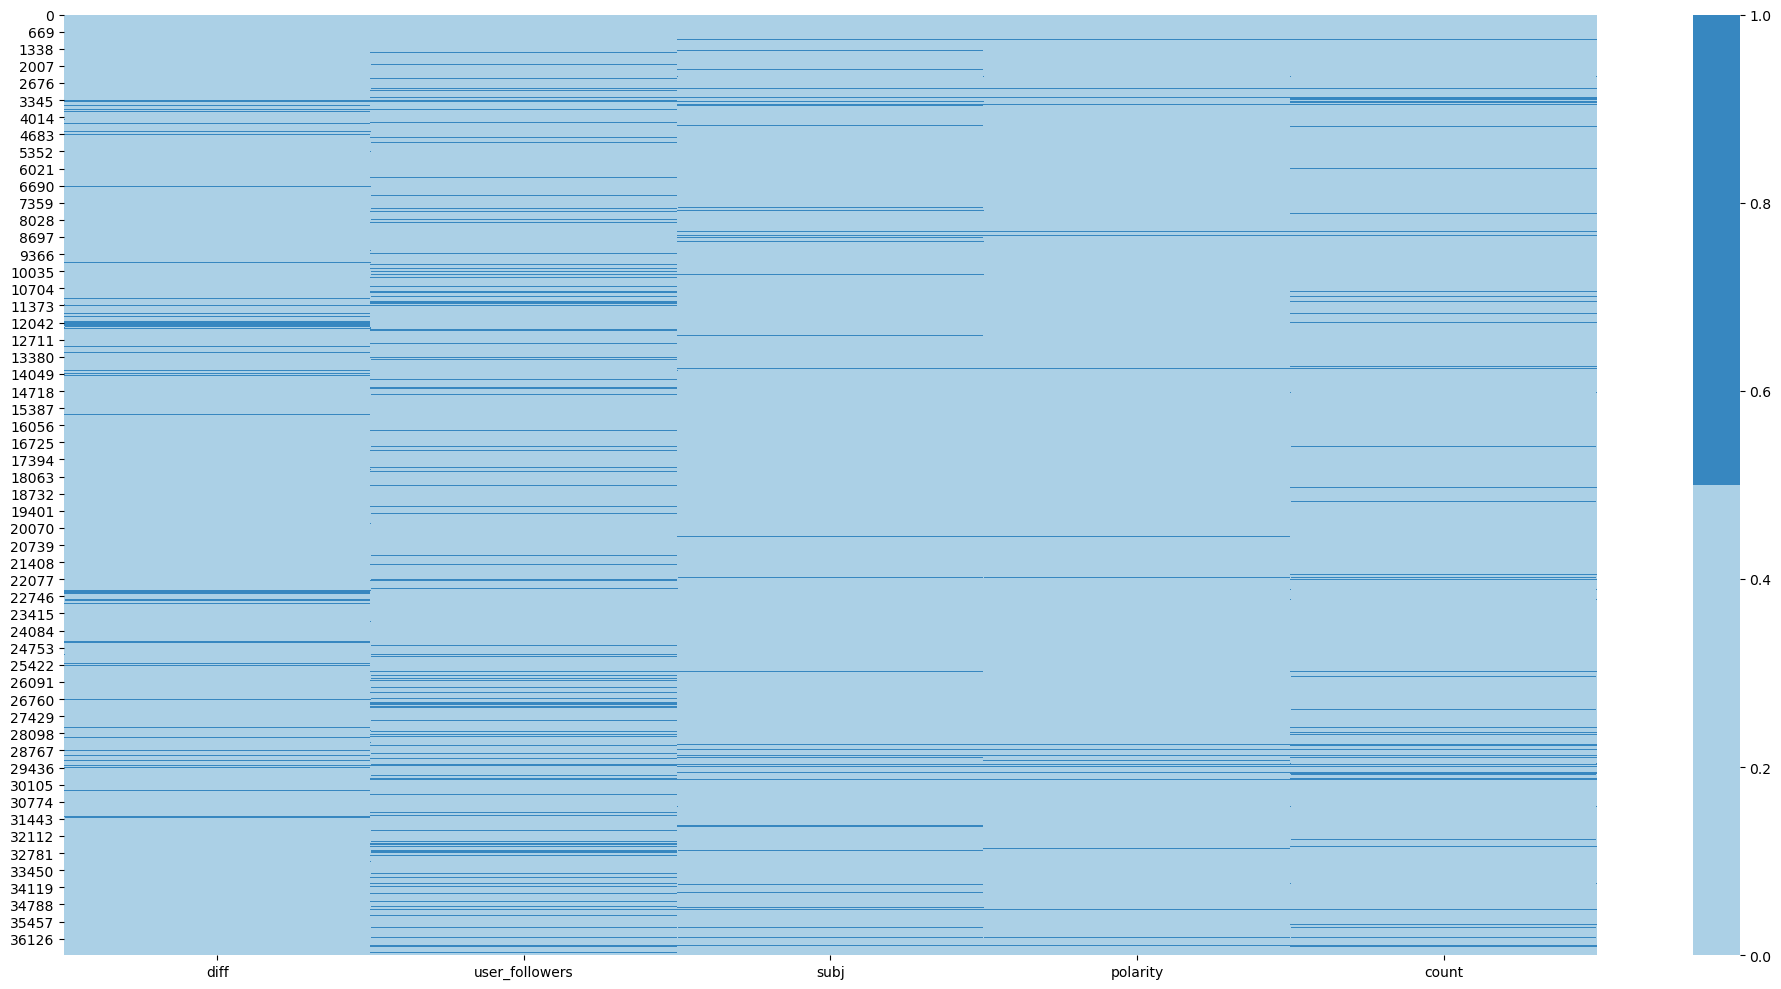

In [24]:
plt.figure(figsize=(20,10))
cmap1=sns.color_palette("Blues",2)
sns.heatmap(df_Bitcoin_price_tweets.isnull(),cmap=cmap1)
plt.tight_layout()
plt.show()

In [25]:
df_Bitcoin_price_tweets.dropna(inplace=True)
df_Bitcoin_price_tweets.reset_index(drop=True,inplace= True)
print('df_Bitcoin_price_tweets dimensions= ',df_Bitcoin_price_tweets.shape)

df_Bitcoin_price_tweets dimensions=  (29437, 5)


Plot Type:  hist
Number of columns:  5


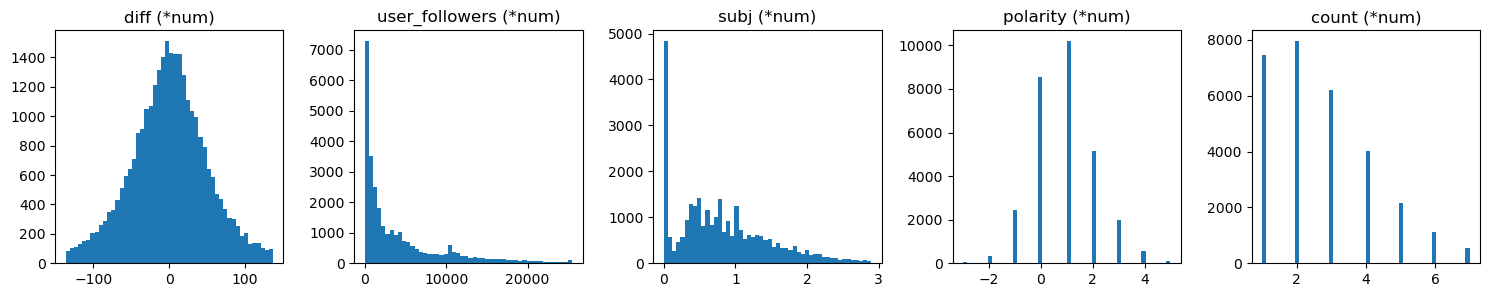

Plot Type:  box
Number of Numeric columns:  5


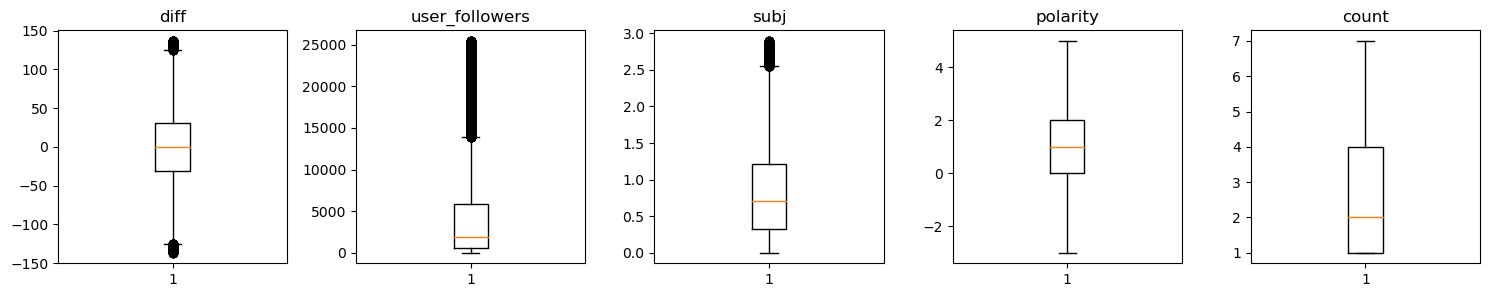

Plot Type:  target_scat
Number of Numeric columns:  5


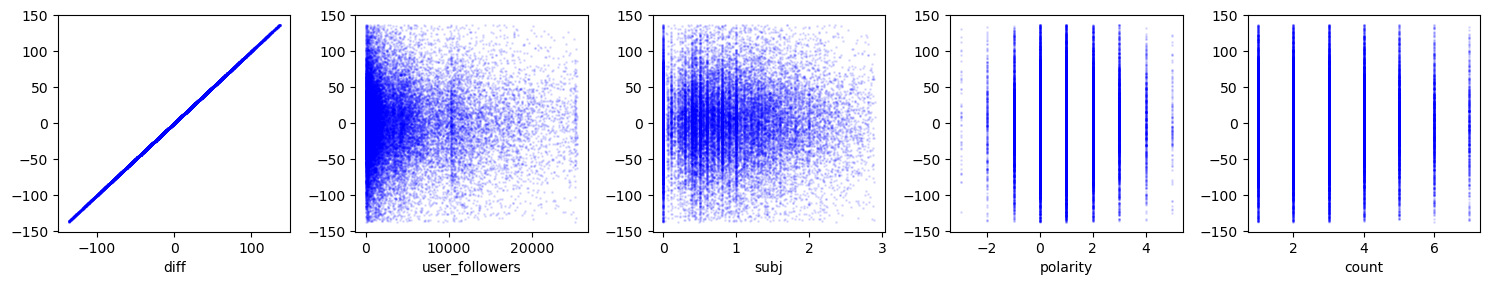

In [26]:
plt_summary(df_Bitcoin_price_tweets,'hist','diff')
plt_summary(df_Bitcoin_price_tweets,'box','diff')
plt_summary(df_Bitcoin_price_tweets,"target_scat",'diff')

In [27]:
X=df_Bitcoin_price_tweets.copy()

target='diff'
inputb='polarity'

# standardization 
# scaler= StandardScaler() 
# X_scaled = scaler.fit_transform(X)
# X=pd.DataFrame(X_scaled,columns=X.columns)

y = X[target].copy() # assigning the target to vector y
X = X[inputb]

X = sm.add_constant(X) #adding constant that will represent the intercept of the MLR model

# Splitting the data into train and test portions
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.30)

# LR implementation
linear_regression = sm.OLS(y_train,X_train)
fitted_model = linear_regression.fit()
residuals =fitted_model.predict(X_test)-y_test
itercept= fitted_model.params[0]
coefficient =fitted_model.params[1]

In [28]:
# MLR summary:
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8079
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.369
Time:                        23:32:24   Log-Likelihood:            -1.0975e+05
No. Observations:               20605   AIC:                         2.195e+05
Df Residuals:                   20603   BIC:                         2.195e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4353      0.433     -1.006      0.3

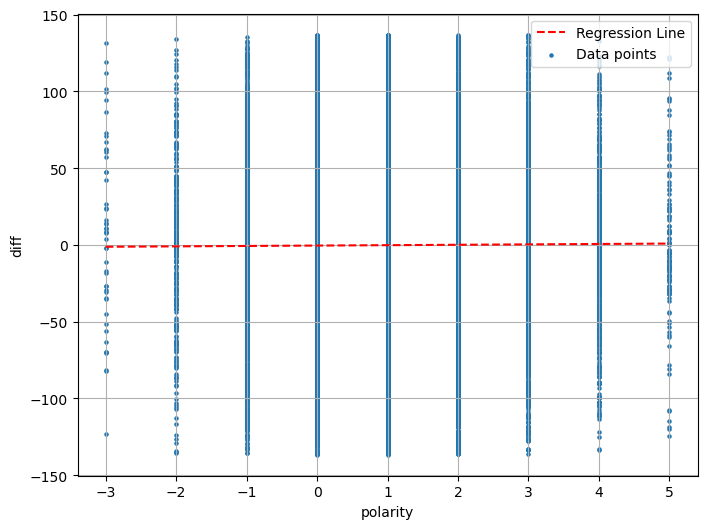

In [29]:
# Linear regression plot
fig, ax = plt.subplots(figsize=(8, 6))
#plt.yscale('log')
plt.scatter((X[inputb]),y,s=5,label='Data points')
line= range(int(X[inputb].min()),int(X[inputb].max()+1))
line2 = sm.add_constant(line)
plt.plot(line,fitted_model.predict(line2),'r--',label='Regression Line')
plt.legend(loc='upper right')
plt.ylabel(target)
plt.xlabel(inputb)
plt.grid()
plt.show()

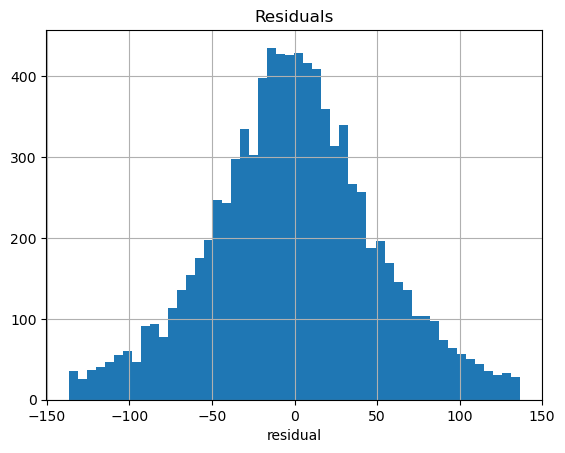

In [30]:
#  MLR examination plots
residuals.hist(bins = 50)
plt.title('Residuals')
plt.xlabel('residual')
plt.show()

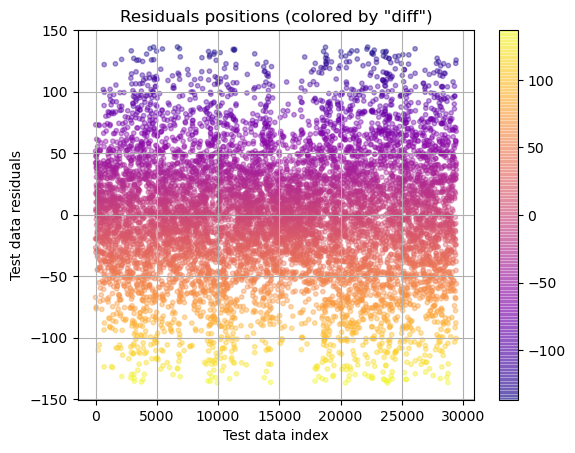

In [31]:
plt.scatter(X_test.index,residuals,s=10,alpha=0.4,c=y_test,cmap='plasma')
plt.title('Residuals positions (colored by "'+ target +'")');plt.xlabel('Test data index');plt.ylabel('Test data residuals')
plt.colorbar();plt.grid('on')
plt.show()

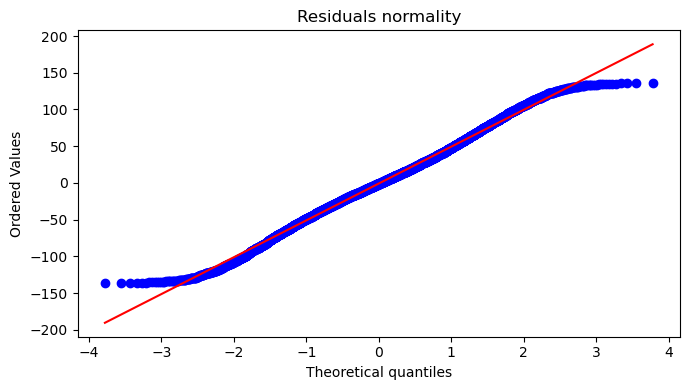

In [32]:
#  QQ-Plot
fig, ax = plt.subplots(figsize=(7, 4))
stats.probplot(residuals, plot=ax) # QQ-Plot
plt.title('Residuals normality')
plt.tight_layout()
plt.show()

In [33]:
def linear_reg_test(df,target,inputb):
    X=df.copy()

    # standardization 
#     scaler= StandardScaler() 
#     X_scaled = scaler.fit_transform(X)
#     X=pd.DataFrame(X_scaled,columns=X.columns)

    y = X[target].copy() # assigning the target to vector y
    X = X[inputb]

    X = sm.add_constant(X) #adding constant that will represent the intercept of the MLR model

    # Splitting the data into train and test portions
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.10)

    # LR implementation
    linear_regression = sm.OLS(y_train,X_train)
    fitted_model = linear_regression.fit()
    residuals =fitted_model.predict(X_test)-y_test

    # MLR summary:
    print(fitted_model.summary())
    r2=fitted_model.rsquared; 
    p_min=min(fitted_model.pvalues[1:])
    p_values=str(fitted_model.pvalues[1:]).replace('\n',', ')
    coefs=str(fitted_model.params[1:]).replace('\n',', ')
    
    
#     MLR examination plots
    residuals.hist(bins = 50)
    plt.title('Residuals')
    plt.xlabel('residual')
    plt.show()

    plt.scatter(X_test.index,residuals,s=20,alpha=0.4,c=y_test,cmap='plasma')
    plt.title('Residuals positions (colored by "'+ target +'")');plt.xlabel('Test data idx');plt.ylabel('Test data residuals')
    plt.colorbar();plt.grid('on')
    plt.show()

#     QQ-Plot
    fig, ax = plt.subplots(figsize=(4, 4))
    stats.probplot(residuals, plot=ax) # QQ-Plot
    plt.title('Residuals normality')
    plt.tight_layout()
    plt.show()
    
    return r2, p_min,p_values[:-14],coefs[:-14]

In [34]:
def all_targets_all_inputs(df,targets,inputs,frame):
    test_number=0
    test_ser=[];r2=[];p_min=[];p_values=[];target_list=[];input_list=[];number_of_inputs=[];frame_list=[];coefs_list=[]
    for targeta in targets:        
        inputs_list=[]
        # one input
        for input1 in inputs:
            inputb = input1
            test_number=test_number+1
            print('Time_Frame= ',frame,'Min')
            print('Test number= ',test_number)
            print('target= ',targeta)
            print('number of inputs= 1')
            print('inputs= ',inputb)
            #print(50*'-')
            inputs_list.append(inputb)
            r2_val, p_min_val,p_values_val,coefs_val=linear_reg_test(df,targeta,inputb)
            print(100*'-')
            coefs_list.append(coefs_val);frame_list.append(frame);test_ser.append(test_number);r2.append(r2_val);p_min.append(p_min_val);p_values.append(p_values_val);target_list.append(targeta);input_list.append(inputb);number_of_inputs.append(1)
            
            
        # two inputs
        for input1 in inputs:
            for input2 in inputs:
                inputb=[]
                if ((input1 == input2)):
                    continue
                inputb.append(input1)
                inputb.append(input2)
                if ((set(inputb) in inputs_list)):
                    continue
                inputs_list.append(set(inputb))
                #print(iputs_list)
                test_number=test_number+1
                print('Time_Frame= ',frame,'Min')
                print('Test number= ',test_number)
                print('target= ',targeta)
                print('number of inputs= ',len(inputb))
                print('inputs= ',inputb)
                #print(50*'-')
                r2_val, p_min_val,p_values_val,coefs_val=linear_reg_test(df,targeta,inputb)
                print(100*'-')
                coefs_list.append(coefs_val);frame_list.append(frame);test_ser.append(test_number);r2.append(r2_val);p_min.append(p_min_val);p_values.append(p_values_val);target_list.append(targeta);input_list.append(inputb);number_of_inputs.append(len(inputb))
                
        # three inputs
        for input1 in inputs:
            for input2 in inputs:
                for input3 in inputs:
                    inputb=[]
                    if ((input1 == input2) or (input1 == input3) or (input2 == input3)):
                        continue
                    inputb.append(input1)
                    inputb.append(input2)
                    inputb.append(input3)
                    if ((set(inputb) in inputs_list)):
                        continue
                    inputs_list.append(set(inputb))
                    #print(iputs_list)
                    test_number=test_number+1
                    print('Time_Frame= ',frame,'Min')
                    print('Test number= ',test_number)
                    print('target= ',targeta)
                    print('number of inputs= ',len(inputb))
                    print('inputs= ',inputb)
                    #print(50*'-')
                    r2_val, p_min_val,p_values_val,coefs_val=linear_reg_test(df,targeta,inputb)
                    print(100*'-')
                    coefs_list.append(coefs_val);frame_list.append(frame);test_ser.append(test_number);r2.append(r2_val);p_min.append(p_min_val);p_values.append(p_values_val);target_list.append(targeta);input_list.append(inputb);number_of_inputs.append(len(inputb))
        # four inputs
        for input1 in inputs:
            for input2 in inputs:
                for input3 in inputs:
                    for input4 in inputs:
                        inputb=[]
                        if ((input1 == input2) or (input1 == input3) or (input1 == input4) or (input2 == input3) or (input2 == input4) or (input3 == input4)):
                            continue
                        inputb.append(input1)
                        inputb.append(input2)
                        inputb.append(input3)
                        inputb.append(input4)
                        if ((set(inputb) in inputs_list)):
                            continue
                        inputs_list.append(set(inputb))
                        #print(iputs_list)
                        test_number=test_number+1
                        print('Time_Frame= ',frame,'Min')
                        print('Test number= ',test_number)
                        print('target= ',targeta)
                        print('number of inputs= ',len(inputb))
                        print('inputs= ',inputb)
                        #print(50*'-')
                        r2_val, p_min_val,p_values_val,coefs_val=linear_reg_test(df,targeta,inputb)
                        print(100*'-')
                        coefs_list.append(coefs_val);frame_list.append(frame);test_ser.append(test_number);r2.append(r2_val);p_min.append(p_min_val);p_values.append(p_values_val);target_list.append(targeta);input_list.append(inputb);number_of_inputs.append(len(inputb))
                        
    data={'Test_no. for target':test_ser,'Target':target_list,'R2':r2,'No. of inputs':number_of_inputs,'min-p':p_min,'Inputs':input_list,'p-values':p_values,'Time_Frame':frame_list,'coefs_list':coefs_list}
    df_all_results = pd.DataFrame(data=data,columns = ['Test_no. for target','Target','R2','No. of inputs','min-p','Inputs','coefs_list','p-values','Time_Frame'])
    
    df_all_results.set_index('Test_no. for target',drop=True,inplace=True)
    return df_all_results        

In [35]:
targets= ['diff']
inputs=['count','user_followers','subj','polarity']

Time_Frame=  1 Min
Test number=  1
target=  diff
number of inputs= 1
inputs=  count
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1198
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.729
Time:                        23:32:27   Log-Likelihood:            -1.4117e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26491   BIC:                         2.824e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

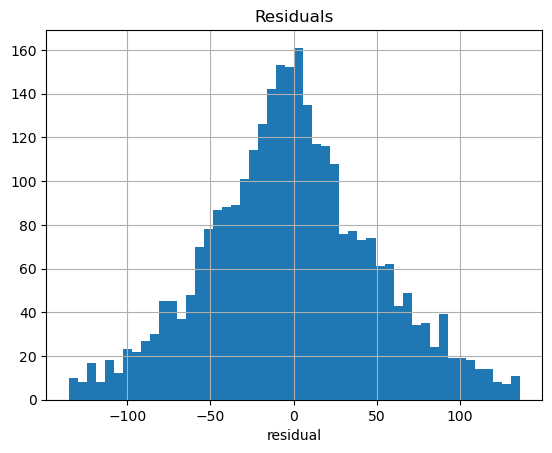

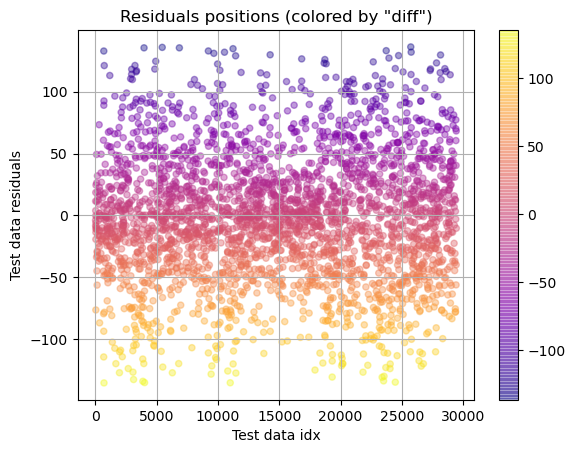

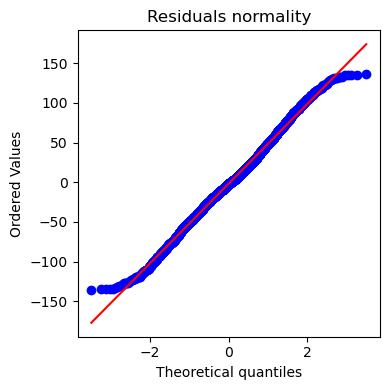

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  2
target=  diff
number of inputs= 1
inputs=  user_followers
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.075
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.300
Time:                        23:32:29   Log-Likelihood:            -1.4114e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26491   BIC:                         2.823e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

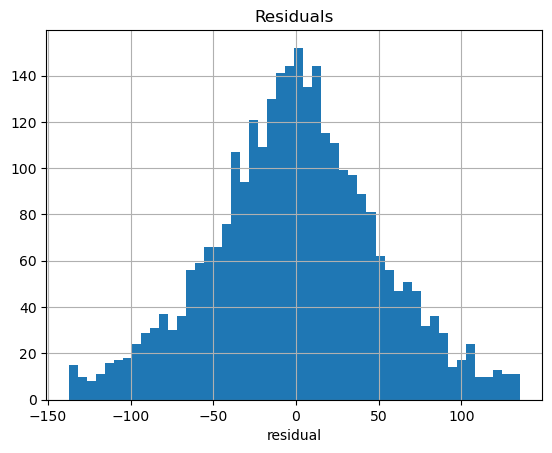

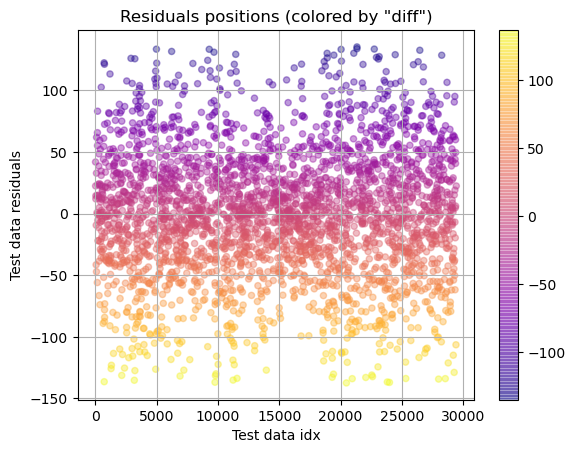

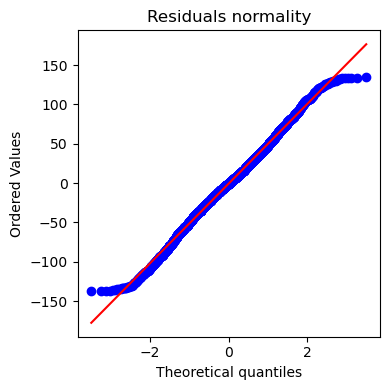

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  3
target=  diff
number of inputs= 1
inputs=  subj
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.801
Date:                Sun, 25 Jul 2021   Prob (F-statistic):             0.0942
Time:                        23:32:31   Log-Likelihood:            -1.4116e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26491   BIC:                         2.823e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    s

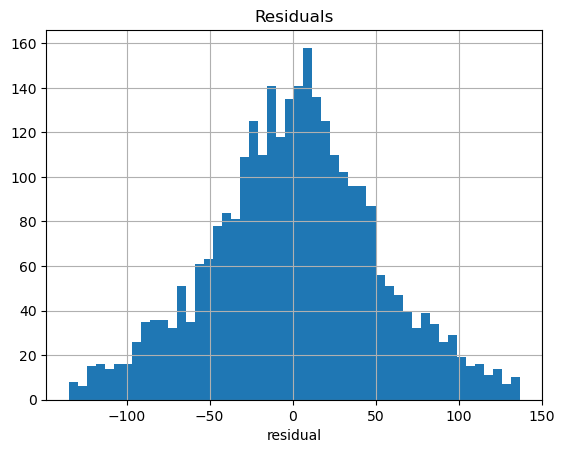

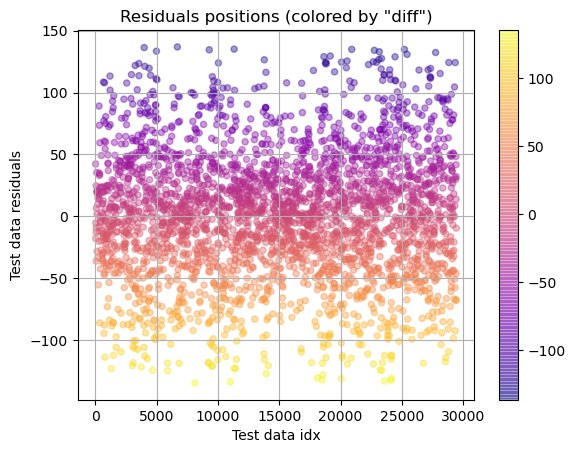

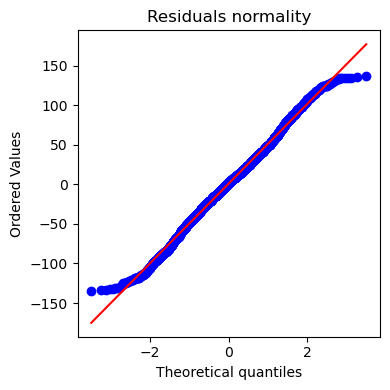

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  4
target=  diff
number of inputs= 1
inputs=  polarity
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.396
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.122
Time:                        23:32:32   Log-Likelihood:            -1.4119e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26491   BIC:                         2.824e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef 

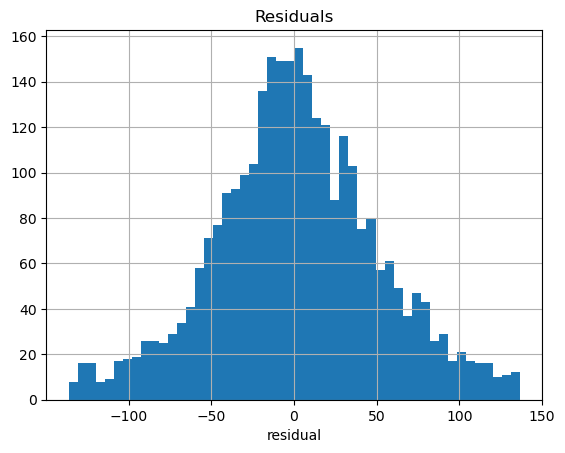

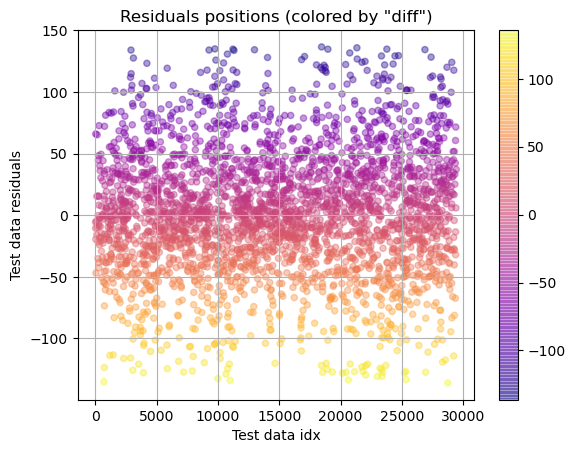

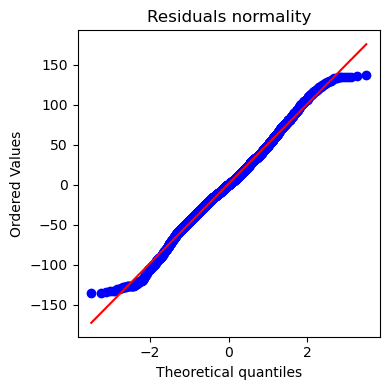

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  5
target=  diff
number of inputs=  2
inputs=  ['count', 'user_followers']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3323
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.717
Time:                        23:32:34   Log-Likelihood:            -1.4114e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26490   BIC:                         2.823e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
  

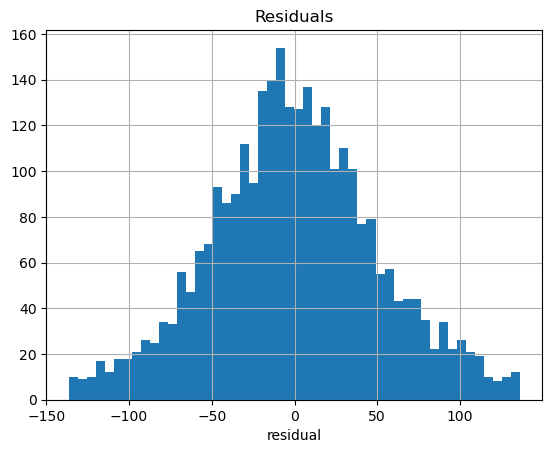

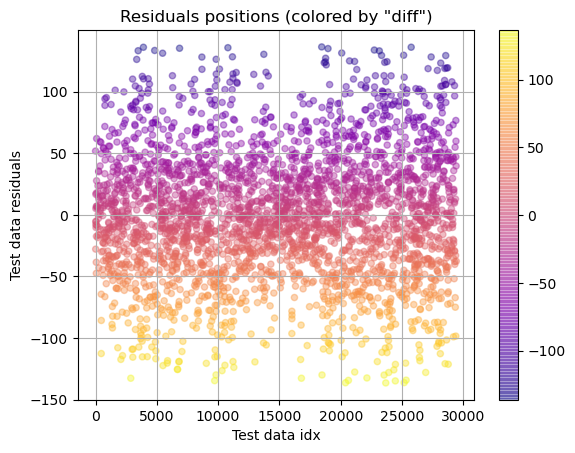

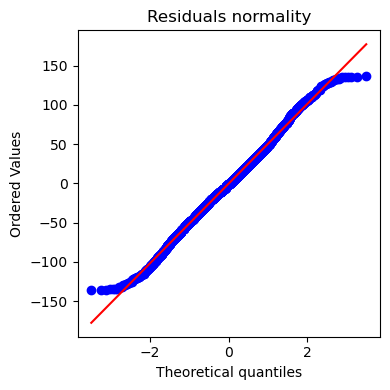

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  6
target=  diff
number of inputs=  2
inputs=  ['count', 'subj']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4587
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.632
Time:                        23:32:35   Log-Likelihood:            -1.4123e+05
No. Observations:               26493   AIC:                         2.825e+05
Df Residuals:                   26490   BIC:                         2.825e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
            

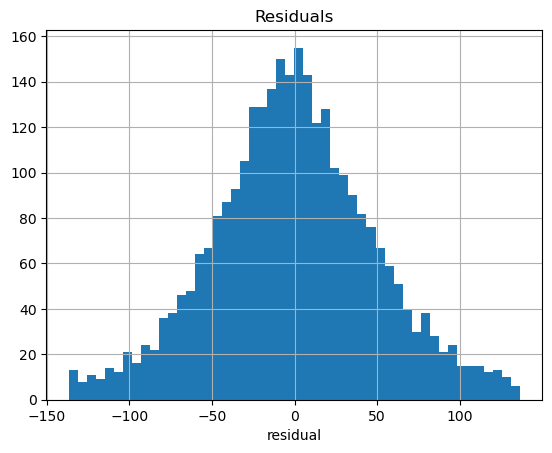

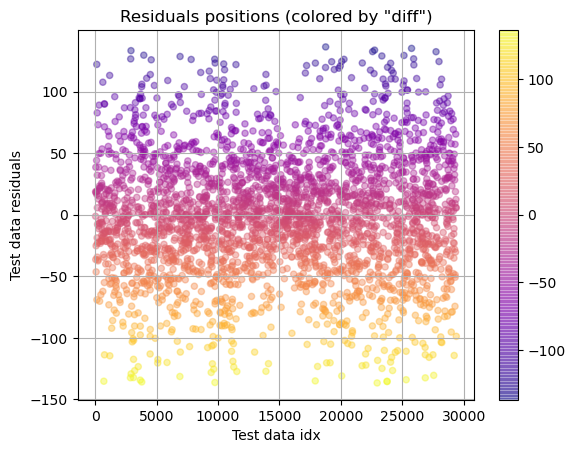

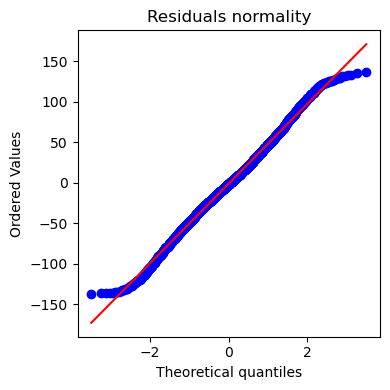

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  7
target=  diff
number of inputs=  2
inputs=  ['count', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.022
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.132
Time:                        23:32:37   Log-Likelihood:            -1.4122e+05
No. Observations:               26493   AIC:                         2.825e+05
Df Residuals:                   26490   BIC:                         2.825e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
        

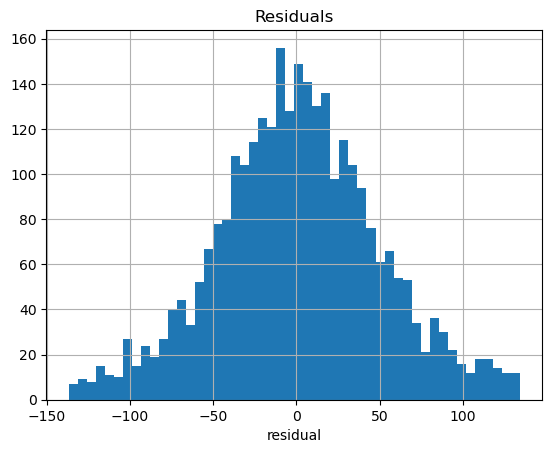

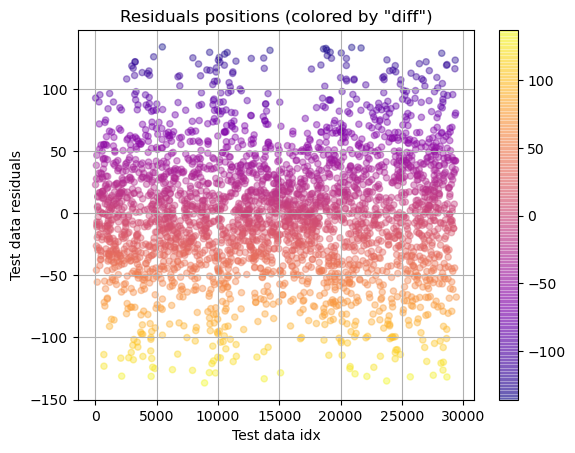

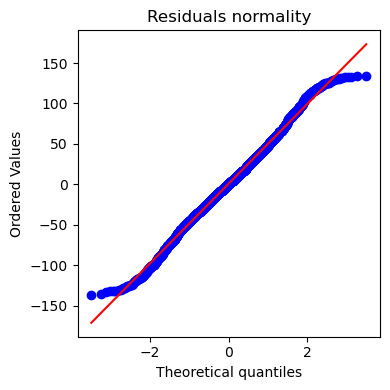

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  8
target=  diff
number of inputs=  2
inputs=  ['user_followers', 'subj']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.596
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.203
Time:                        23:32:39   Log-Likelihood:            -1.4120e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26490   BIC:                         2.824e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
   

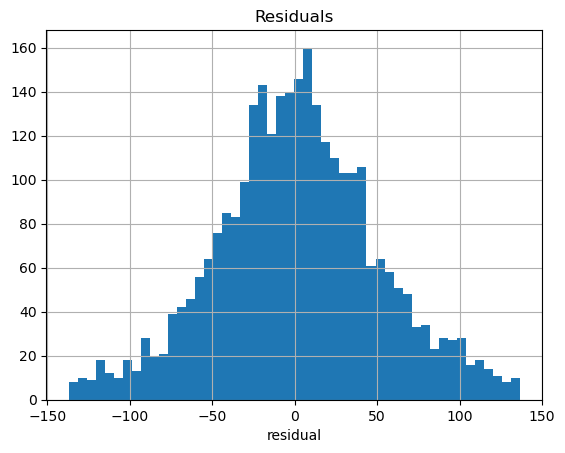

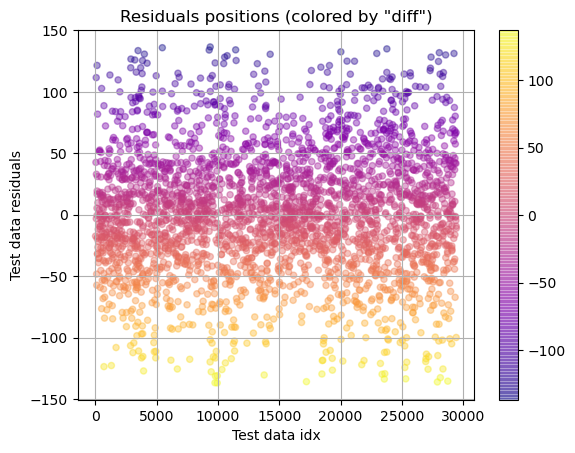

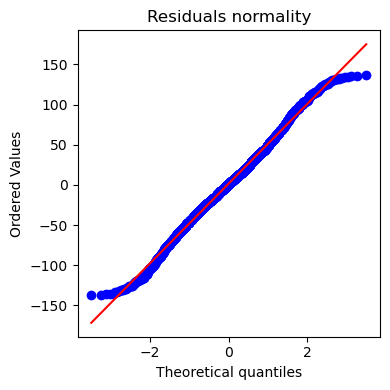

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  9
target=  diff
number of inputs=  2
inputs=  ['user_followers', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.019
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.133
Time:                        23:32:41   Log-Likelihood:            -1.4111e+05
No. Observations:               26493   AIC:                         2.822e+05
Df Residuals:                   26490   BIC:                         2.822e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         

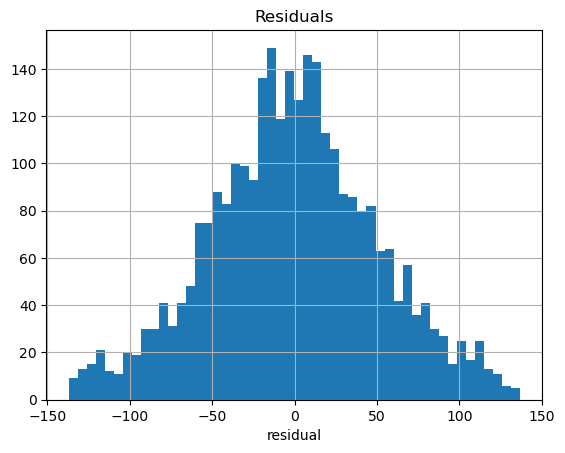

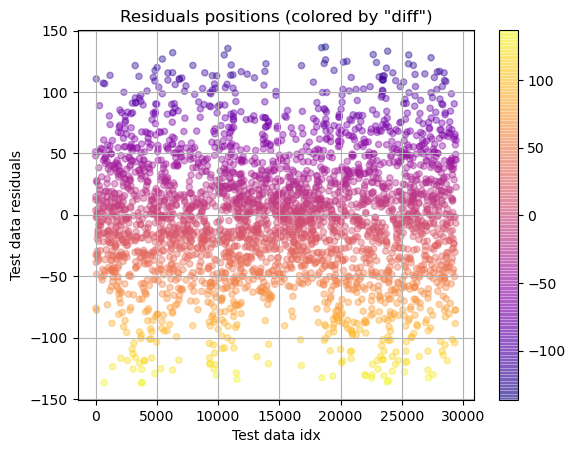

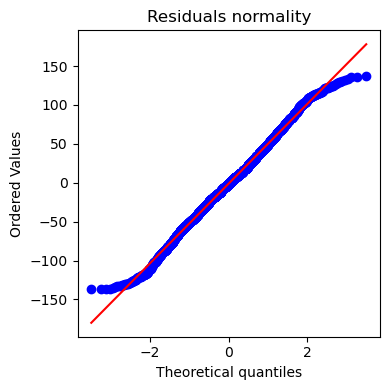

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  10
target=  diff
number of inputs=  2
inputs=  ['subj', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.201
Time:                        23:32:42   Log-Likelihood:            -1.4117e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26490   BIC:                         2.824e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
        

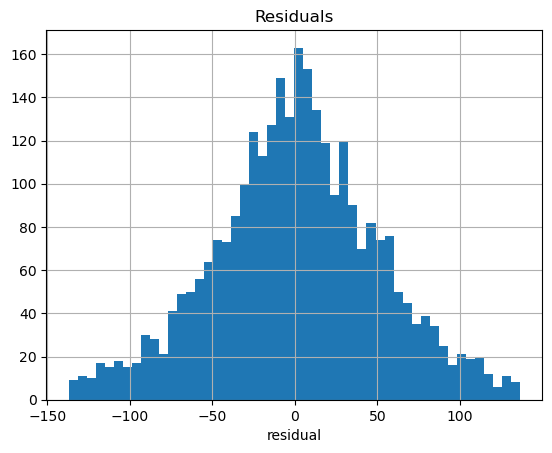

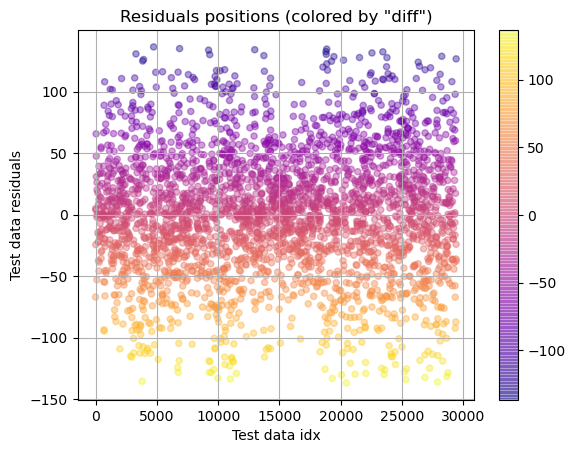

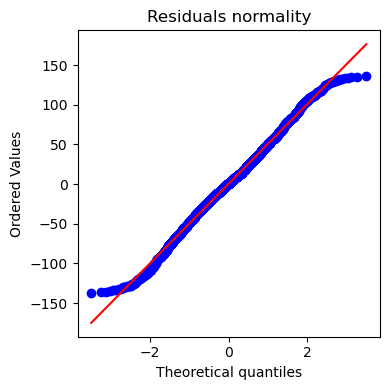

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  11
target=  diff
number of inputs=  3
inputs=  ['count', 'user_followers', 'subj']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.819
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.141
Time:                        23:32:44   Log-Likelihood:            -1.4120e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26489   BIC:                         2.824e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                   

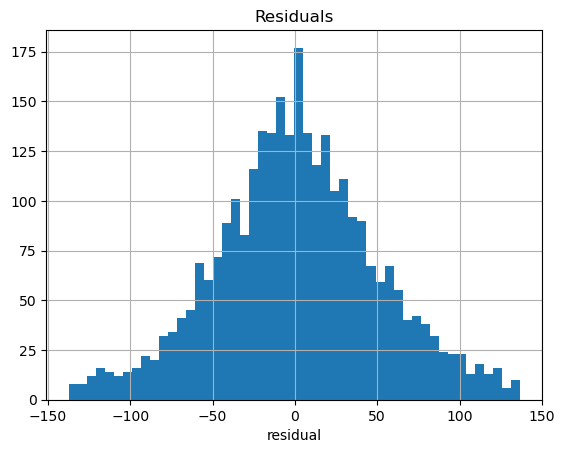

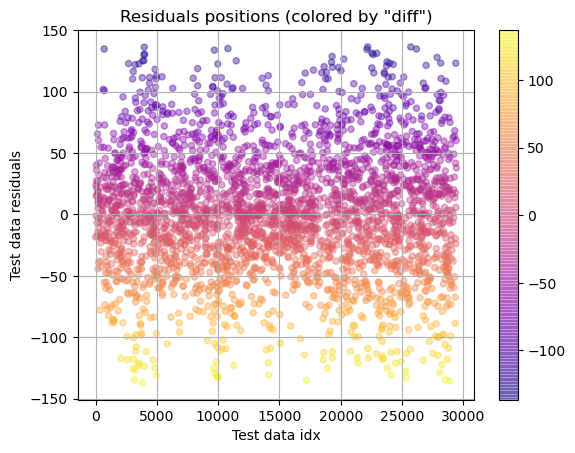

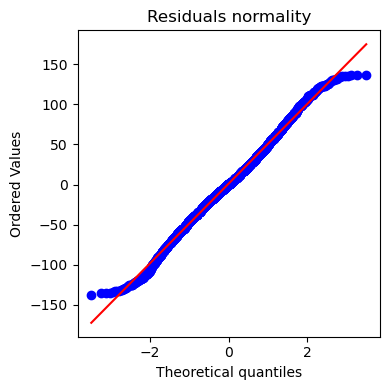

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  12
target=  diff
number of inputs=  3
inputs=  ['count', 'user_followers', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8833
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.449
Time:                        23:32:46   Log-Likelihood:            -1.4120e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26489   BIC:                         2.824e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                               

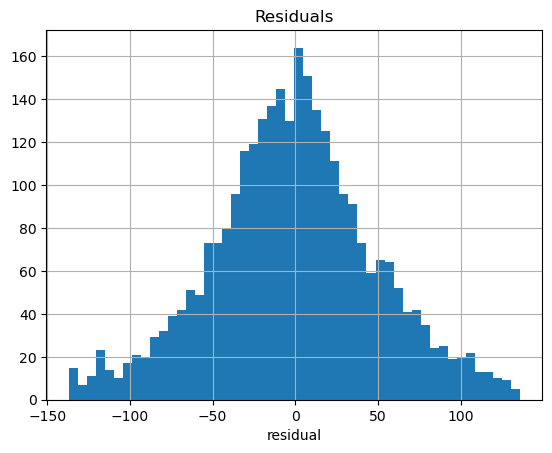

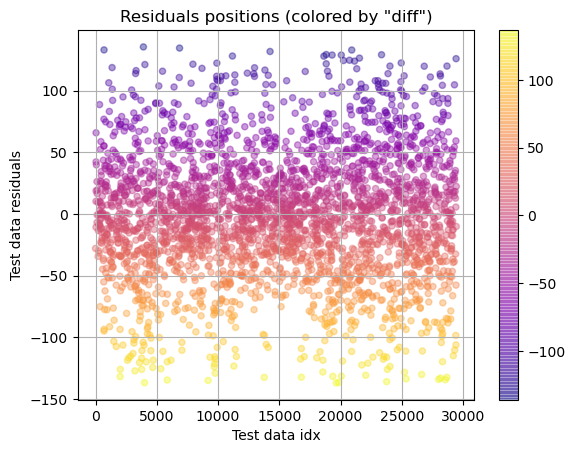

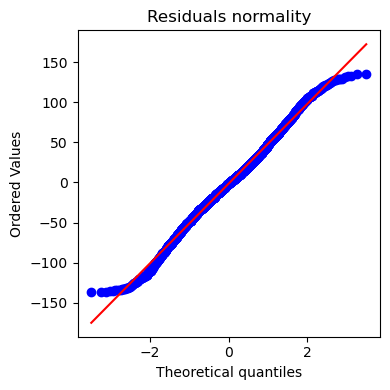

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  13
target=  diff
number of inputs=  3
inputs=  ['count', 'subj', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.306
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.271
Time:                        23:32:48   Log-Likelihood:            -1.4115e+05
No. Observations:               26493   AIC:                         2.823e+05
Df Residuals:                   26489   BIC:                         2.823e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         

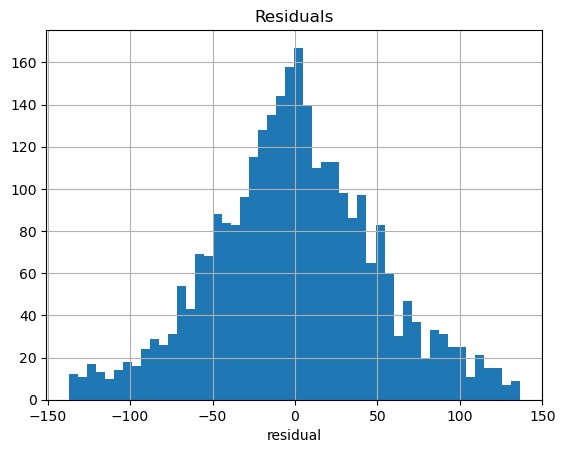

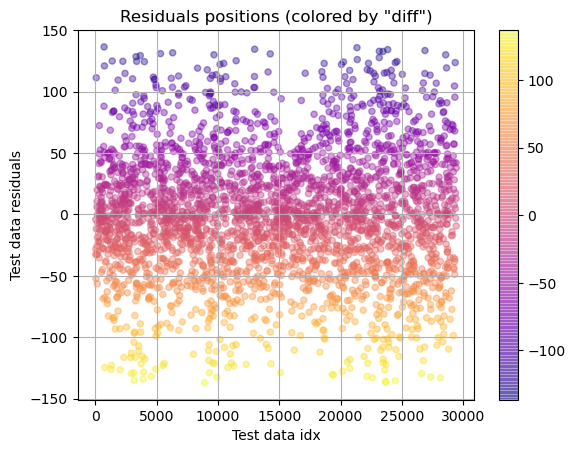

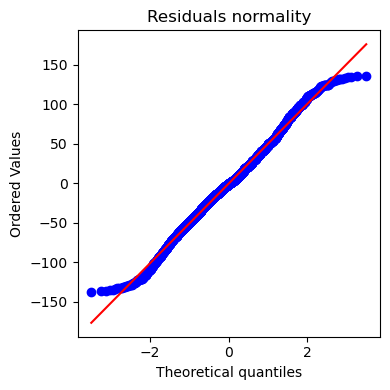

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  14
target=  diff
number of inputs=  3
inputs=  ['user_followers', 'subj', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.269
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.283
Time:                        23:32:49   Log-Likelihood:            -1.4120e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26489   BIC:                         2.824e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                

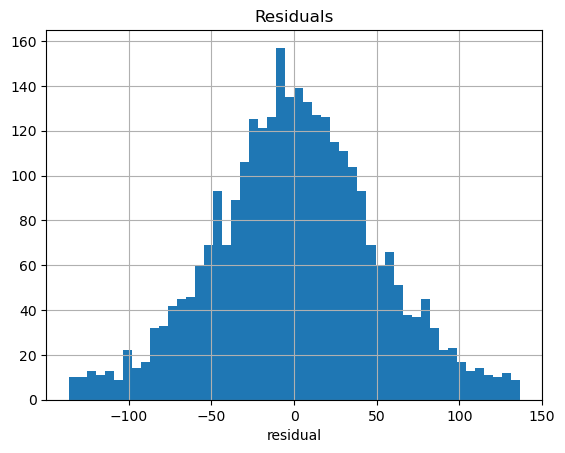

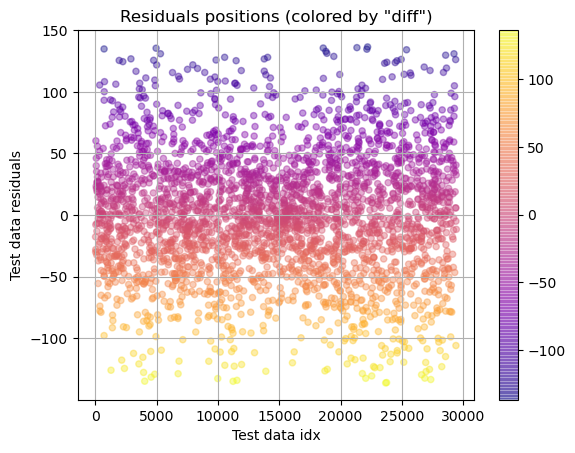

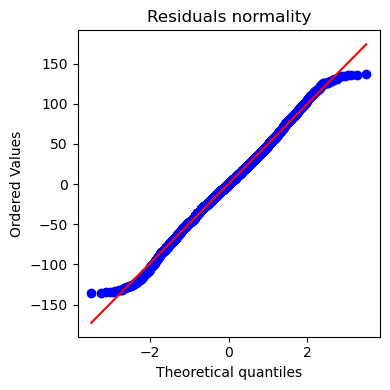

----------------------------------------------------------------------------------------------------
Time_Frame=  1 Min
Test number=  15
target=  diff
number of inputs=  4
inputs=  ['count', 'user_followers', 'subj', 'polarity']
                            OLS Regression Results                            
Dep. Variable:                   diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.287
Date:                Sun, 25 Jul 2021   Prob (F-statistic):              0.273
Time:                        23:32:51   Log-Likelihood:            -1.4122e+05
No. Observations:               26493   AIC:                         2.824e+05
Df Residuals:                   26488   BIC:                         2.825e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                       

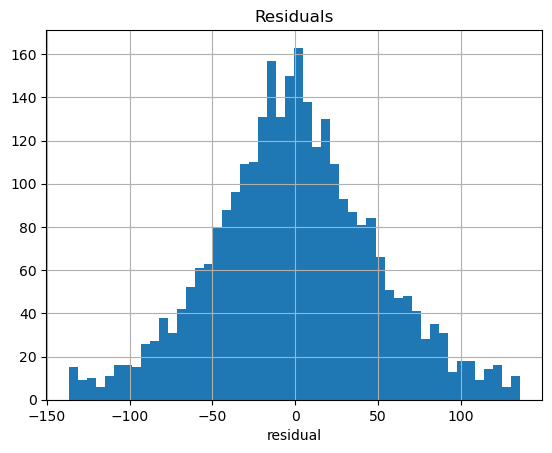

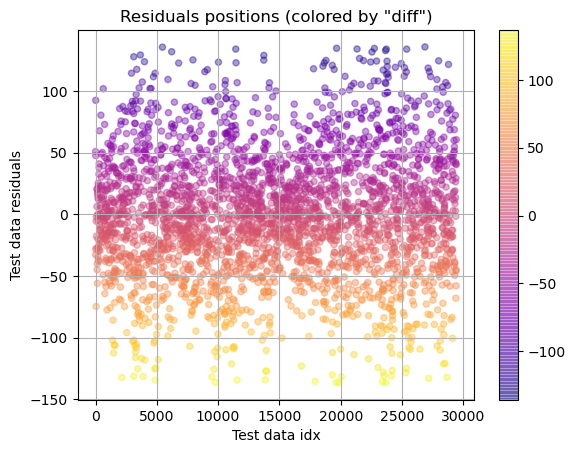

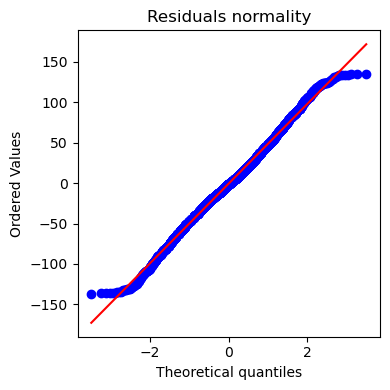

----------------------------------------------------------------------------------------------------


In [36]:
df_all_results=all_targets_all_inputs(df_Bitcoin_price_tweets,targets,inputs,'1')

In [37]:
df_all_results.drop(['min-p','Inputs','Time_Frame'],axis=1).sort_values(by='No. of inputs',axis=0,ascending=True)

Target        R2  No. of inputs  \
Test_no. for target                                   
1                     diff  0.000005              1   
2                     diff  0.000041              1   
3                     diff  0.000106              1   
4                     diff  0.000090              1   
5                     diff  0.000025              2   
6                     diff  0.000035              2   
7                     diff  0.000153              2   
8                     diff  0.000121              2   
9                     diff  0.000152              2   
10                    diff  0.000121              2   
11                    diff  0.000206              3   
12                    diff  0.000100              3   
13                    diff  0.000148              3   
14                    diff  0.000144              3   
15                    diff  0.000194              4   

                                                                                                                           coefs_list  \
Test_no. for target                                                                                                                     
1                                                                                                                 count    0.070443,    
2                                                                                                        user_followers   -0.000059,    
3                                                                                                                  subj    0.786481,    
4                                                                                                              polarity    0.396712,    
5                                                                            count             0.079408, user_followers   -0.000051,    
6                                                                                              count   -0.111659, subj     0.565706,    
7                                                                                        count      -0.101364, polarity    0.551455,    
8                                                                            user_followers   -0.000087, subj              0.601098,    
9                                                                            user_followers   -0.000082, polarity          0.396817,    
10                                                                                       subj        0.527257, polarity    0.233137,    
11                                               count            -0.177011, user_followers   -0.000068, subj              1.191447,    
12                                               count             0.043654, user_followers   -0.000064, polarity          0.322860,    
13                                                                 count      -0.343421, subj        0.999482, polarity    0.158694,    
14                                               user_followers   -0.000075, subj              0.411313, polarity          0.259154,    
15                   count             0.064050, user_followers   -0.000088, subj              0.707264, polarity          0.135881,    

                                                                                                                             p-values  
Test_no. for target                                                                                                                    
1                                                                                                                 count    0.729298,   
2                                                                                                        user_followers    0.299806,   
3                                                                                                                  subj    0.094235,   
4                                                                         